In [75]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [76]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks, checks_and_balances
checks_and_balances()
set_seed(seed=42)

Mixed precision is enabled with policy 'mixed_float16'. GPU compute capability: 8.9
Random seed set to 42


In [77]:
load_fraction = 1.0             # Full data load
batch_size = 8                 # We are low on resources. We will go slow and steady.
image_size = (120, 120)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
)

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
)

# Get the first batch
X, y = train_generator[0]

# Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

83 batches created, each of size 8, with 663 sequences of 30 images each. Use MediaPipe: False
13 batches created, each of size 8, with 100 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (8, 30, 120, 120, 3)
Labels batch shape (y): (8, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]


In [78]:
# Define parameters
sequence_length = train_generator.sequence_length                 # Frames per video (from generator)
image_size = train_generator.image_size                           # Image size (height, width)
num_classes = train_generator.num_classes                         # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # Conv3D input shape

In [79]:
from tensorflow.keras import layers, models, regularizers

# Define the model
model = models.Sequential([
    # Input layer
    layers.Input(shape=(sequence_length, None, None, 3)),  # Input shape: (timesteps, height, width, channels)

    # Smaller CNN layers for feature extraction
    layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    # Global average pooling to reduce parameters
    layers.TimeDistributed(layers.GlobalAveragePooling2D()),

    # RNN layer for temporal modeling
    layers.Bidirectional(layers.GRU(32, return_sequences=False, recurrent_activation='sigmoid')),  # cuDNN-compatible configuration

    # Fully connected layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.4),

    # Output layer
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_70 (TimeDi  (None, 30, None, None, 1  448      
 stributed)                  6)                                  
                                                                 
 time_distributed_71 (TimeDi  (None, 30, None, None, 1  64       
 stributed)                  6)                                  
                                                                 
 time_distributed_72 (TimeDi  (None, 30, None, None, 1  0        
 stributed)                  6)                                  
                                                                 
 time_distributed_73 (TimeDi  (None, 30, None, None, 3  4640     
 stributed)                  2)                                  
                                                                 
 time_distributed_74 (TimeDi  (None, 30, None, None, 3

In [80]:
model_save_location = 'best-models/Conv2D+GRU'

In [81]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(
    filepath = model_save_location, 
    save_best_only=True)

Epoch 1/50
83/83 [==============================] - 38s 416ms/step - loss: 2.0021 - accuracy: 0.3665 - val_loss: 2.3891 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50
83/83 [==============================] - 34s 408ms/step - loss: 1.6324 - accuracy: 0.4902 - val_loss: 2.9678 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 3/50
83/83 [==============================] - 33s 402ms/step - loss: 1.4821 - accuracy: 0.5204 - val_loss: 3.1746 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 4/50
83/83 [==============================] - 35s 427ms/step - loss: 1.2876 - accuracy: 0.6048 - val_loss: 2.9452 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 5/50
83/83 [==============================] - 36s 430ms/step - loss: 1.1431 - accuracy: 0.6606 - val_loss: 2.8704 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/50
83/83 [==============================] - 34s 414ms/step - loss: 1.0654 - accuracy: 0.6621 - val_loss: 1.9994 - val_accuracy: 0.3200 - lr: 0.0010
Epoch 7/50
83/83 [==============================] - 34s 403ms/st

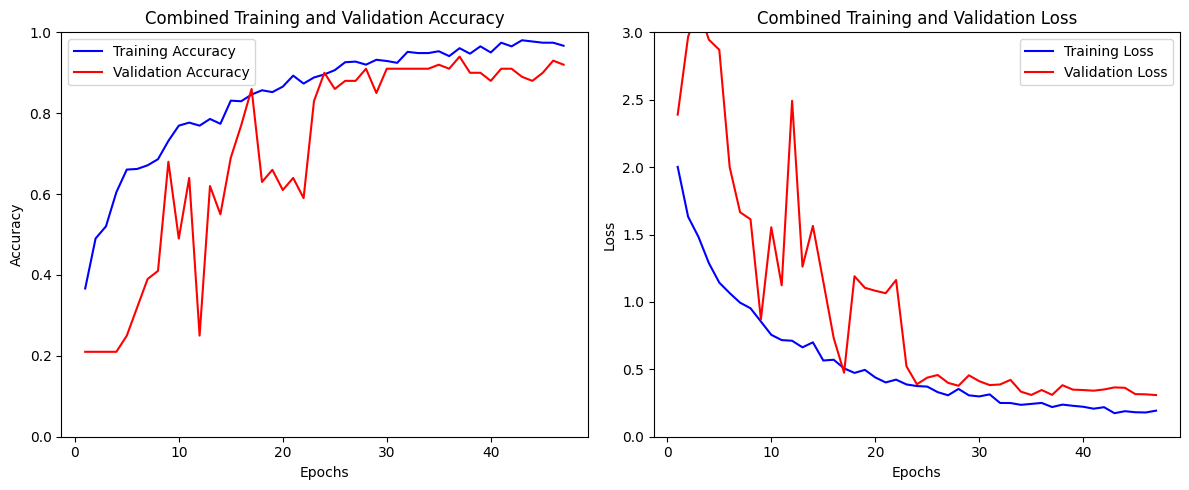

In [82]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

In [83]:
model.load_weights(f'{model_save_location}.keras')

evaluation_results = model.evaluate(val_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

13/13 [==============================] - 5s 382ms/step - loss: 0.3106 - accuracy: 0.9400
loss: 0.3106
accuracy: 0.9400


In [84]:
model.load_weights(f'{model_save_location}.keras')

evaluation_results = model.evaluate(train_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")

83/83 [==============================] - 28s 330ms/step - loss: 0.1427 - accuracy: 0.9879
loss: 0.1427
accuracy: 0.9879
